In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import geopy
from geopy.geocoders import Nominatim

from catboost import CatBoostRegressor
import optuna

In [3]:
df = pd.read_csv('realty_data.csv')
df

,product_name,period,price,postcode,address_name,lat,lon,object_type,total_square,rooms,floor,city,settlement,district,area,description,source
0,"3-комнатная, 137 м²",NaN,63000000,127473.0,"2-й Щемиловский переулок, 5а",55.778894,37.608844,Квартира,137.0,3.0,6.0,Москва,NaN,Тверской район,NaN,Просторная квартира свободной планировки с пан...,ЦИАН
1,"Студия, 16,7 м²",NaN,3250000,108815.0,"Харлампиева, 46",55.551025,37.313054,Квартира,16.7,NaN,1.0,Москва,NaN,Филимонковское поселение,NaN,ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...,Домклик
2,"3-комнатная, 76 м²",NaN,16004680,NaN,"ЖК Прокшино, 8 к4",55.594802,37.431264,Квартира,76.0,3.0,6.0,Москва,NaN,Сосенское поселение,NaN,"Apт.1684018. 0,01% - гибкая ипотека! Воспользу...",Яндекс.Недвижимость
3,"1-комнатная, 24 м²",NaN,7841776,NaN,"ЖК Прокшино, 6 к2",55.594332,37.428099,Квартира,24.0,1.0,10.0,Москва,NaN,Сосенское поселение,NaN,Продается однокомнатная квартира № 381 в новос...,Новострой-М
4,"3-комнатная, 126 м²",NaN,120000000,121352.0,"Давыдковская, 18",55.721097,37.464342,Квартира,126.0,3.0,16.0,Москва,NaN,Фили-Давыдково район,NaN,Шикарное предложение!\nПродаётся трёхкомнатная...,Домклик
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98817,"2-комнатная, 42 м²",NaN,12183528,125212.0,"Кронштадтский бульвар, 9 к1/3",55.842935,37.487680,Квартира,42.0,2.0,8.0,Москва,NaN,Головинский район,NaN,Продаётся 2-комн.квартира площадью 42.00 кв.м ...,Яндекс.Недвижимость
98818,"2-комнатная, 63,5 м²",NaN,34925000,129090.0,"Олимпийский проспект, вл10",55.777354,37.621747,Квартира,63.5,2.0,3.0,Москва,NaN,Мещанский район,NaN,С 1 октября повышение цен на 5% на апартаменты...,ЦИАН
98819,"1-комнатная, 34,4 м²",NaN,10000000,117534.0,"Чертановская улица, 53 к1",55.602124,37.591573,Квартира,34.4,1.0,3.0,Москва,NaN,Чертаново Южное район,NaN,Продажа идеальной однокомнатной квартиры. Безу...,Домклик
98820,"3-комнатная, 56 м²",NaN,15999000,109518.0,"1-й Грайвороновский проезд, 3",55.719431,37.724875,Квартира,56.0,3.0,11.0,Москва,NaN,Текстильщики район,NaN,"Новостройка! Евротрешка , две раздельная комна...",Домклик


- product_name - наименование объекта недвижимости
- period - дата
- postcode - почтовый индекс
- address_name - адрес объекта
- lat - координаты (широта)
- lon - координаты (долгота)
- object_type - тип объекта
- total_square - общая площадь
- rooms - количество комнат
- floor - этаж
- city - город
- settlement - населенный пункт
- district - район
- area - микрорайон
- description - текст объявления
- source - источник

In [4]:
df.isna().sum()

product_name        0
period          98822
price               0
postcode         5147
address_name        1
lat                 0
lon                 0
object_type         0
total_square        0
rooms            3982
floor               0
city             6894
settlement      91928
district        23711
area            79324
description       249
source              0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98822 entries, 0 to 98821
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  98822 non-null  object 
 1   period        0 non-null      float64
 2   price         98822 non-null  int64  
 3   postcode      93675 non-null  float64
 4   address_name  98821 non-null  object 
 5   lat           98822 non-null  float64
 6   lon           98822 non-null  float64
 7   object_type   98822 non-null  object 
 8   total_square  98822 non-null  float64
 9   rooms         94840 non-null  float64
 10  floor         98822 non-null  float64
 11  city          91928 non-null  object 
 12  settlement    6894 non-null   object 
 13  district      75111 non-null  object 
 14  area          19498 non-null  object 
 15  description   98573 non-null  object 
 16  source        98822 non-null  object 
dtypes: float64(7), int64(1), object(9)
memory usage: 12.8+ MB


In [6]:
df['lat'] = df['lat'].astype(str)
df['lon'] = df['lon'].astype(str)

df['postcode'] = df['postcode'].astype(str)

## Заполнение пропусков в геоданных 

In [7]:
# postcode
def NA(df,index,col,name_geopy):
    geolocator = Nominatim(user_agent="geoapiExercises")
    for i in index:
        Latitude = df['lat'].iloc[i]
        Longitude =df['lon'].iloc[i]
        location = geolocator.reverse(Latitude+","+Longitude)
        address = location.raw['address']
        col.iloc[i] = address.get(name_geopy)
    return df

# district
def NA_district(df,index,col,name_geopy_one,name_geopy_two):
    geolocator = Nominatim(user_agent="geoapiExercises")
    for i in index:
        Latitude = df['lat'].iloc[i]
        Longitude =df['lon'].iloc[i]
        location = geolocator.reverse(Latitude+","+Longitude)
        address = location.raw['address']
        
        if address.get(name_geopy_one):
            col.iloc[i] = address.get(name_geopy_one)
        elif address.get(name_geopy_two):
            col.iloc[i] = address.get(name_geopy_two)
        else:
            continue
        
    return df

# area
def NA_area(df,index,col,name_geopy_one,name_geopy_two):
    geolocator = Nominatim(user_agent="geoapiExercises")
    for i in index:
        Latitude = df['lat'].iloc[i]
        Longitude =df['lon'].iloc[i]
        location = geolocator.reverse(Latitude+","+Longitude)
        address = location.raw['address']
        
        if address.get(name_geopy_one):
            col.iloc[i] = address.get(name_geopy_one)
        elif address.get(name_geopy_two):
            col.iloc[i] = address.get(name_geopy_two)
        else:
            continue
        
    return df


In [8]:
#  вызов функций
# NA(df,index_na_postcode,  df['postcode'], 'postcode')
# NA_district(df,index_na_district,  df['district'], 'suburb', 'municipality')
# NA_area(df,index_na_area,  df['area'], 'residential', 'neighbourhood')

# запись полученных результатов
# df.to_csv('fill_df.csv', index = False)

##  Импорт заполненного файла 

In [9]:
df = pd.read_csv('fill_df.csv')
df.head()

,product_name,period,price,postcode,address_name,lat,lon,object_type,total_square,rooms,floor,city,settlement,district,area,description,source
0,"3-комнатная, 137 м²",NaN,63000000,127473.0,"2-й Щемиловский переулок, 5а",55.778894,37.608844,Квартира,137.0,3.0,6.0,Москва,NaN,Тверской район,NaN,Просторная квартира свободной планировки с пан...,ЦИАН
1,"Студия, 16,7 м²",NaN,3250000,108815.0,"Харлампиева, 46",55.551025,37.313054,Квартира,16.7,NaN,1.0,Москва,NaN,Филимонковское поселение,NaN,ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...,Домклик
2,"3-комнатная, 76 м²",NaN,16004680,108802.0,"ЖК Прокшино, 8 к4",55.594802,37.431264,Квартира,76.0,3.0,6.0,Москва,NaN,Сосенское поселение,NaN,"Apт.1684018. 0,01% - гибкая ипотека! Воспользу...",Яндекс.Недвижимость
3,"1-комнатная, 24 м²",NaN,7841776,108802.0,"ЖК Прокшино, 6 к2",55.594332,37.428099,Квартира,24.0,1.0,10.0,Москва,NaN,Сосенское поселение,NaN,Продается однокомнатная квартира № 381 в новос...,Новострой-М
4,"3-комнатная, 126 м²",NaN,120000000,121352.0,"Давыдковская, 18",55.721097,37.464342,Квартира,126.0,3.0,16.0,Москва,NaN,Фили-Давыдково район,NaN,Шикарное предложение!\nПродаётся трёхкомнатная...,Домклик


# EDA

In [10]:
df.isna().sum()

product_name        0
period          98822
price               0
postcode            0
address_name        1
lat                 0
lon                 0
object_type         0
total_square        0
rooms            3982
floor               0
city             6894
settlement      91928
district        12087
area            66102
description       249
source              0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98822 entries, 0 to 98821
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  98822 non-null  object 
 1   period        0 non-null      float64
 2   price         98822 non-null  int64  
 3   postcode      98822 non-null  float64
 4   address_name  98821 non-null  object 
 5   lat           98822 non-null  float64
 6   lon           98822 non-null  float64
 7   object_type   98822 non-null  object 
 8   total_square  98822 non-null  float64
 9   rooms         94840 non-null  float64
 10  floor         98822 non-null  float64
 11  city          91928 non-null  object 
 12  settlement    6894 non-null   object 
 13  district      86735 non-null  object 
 14  area          32720 non-null  object 
 15  description   98573 non-null  object 
 16  source        98822 non-null  object 
dtypes: float64(7), int64(1), object(9)
memory usage: 12.8+ MB


In [12]:
df['postcode'] = df['postcode'].astype(str)
df['rooms'] = df['rooms'].astype(str)


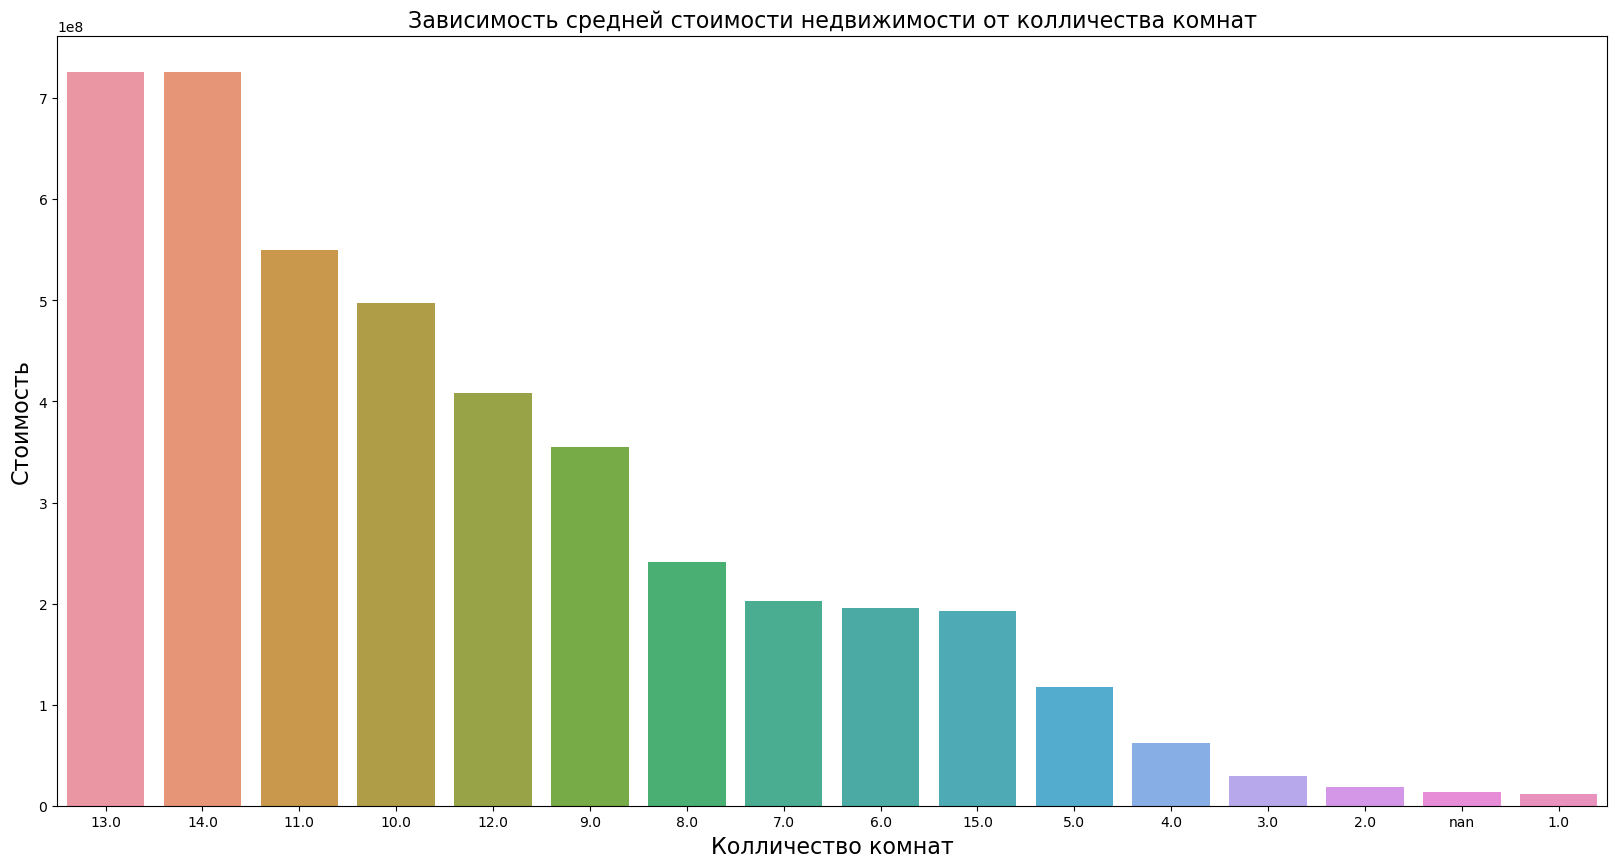

In [13]:
plt.figure(figsize = (20,10))
mean_price_rooms = (df.groupby(['rooms'])[['price']].mean().sort_values('price',ascending=False))
mean_price_rooms['col'] = mean_price_rooms.index
sns.barplot(data=mean_price_rooms, x = 'col', y = 'price')
plt.ylabel('Стоимость', fontsize=16)
plt.xlabel('Колличество комнат', fontsize=16)
plt.title('Зависимость средней стоимости недвижимости от колличества комнат',fontsize=16)

plt.show()

- присутствует тренд возрастания стоимости недвижимости с возрастанием колличества комнат. 
- возможно присутсвуют выбросы или продажа отдельных сигментов недвижимости по специальным условиям. Необходима дополнительная аналитика 

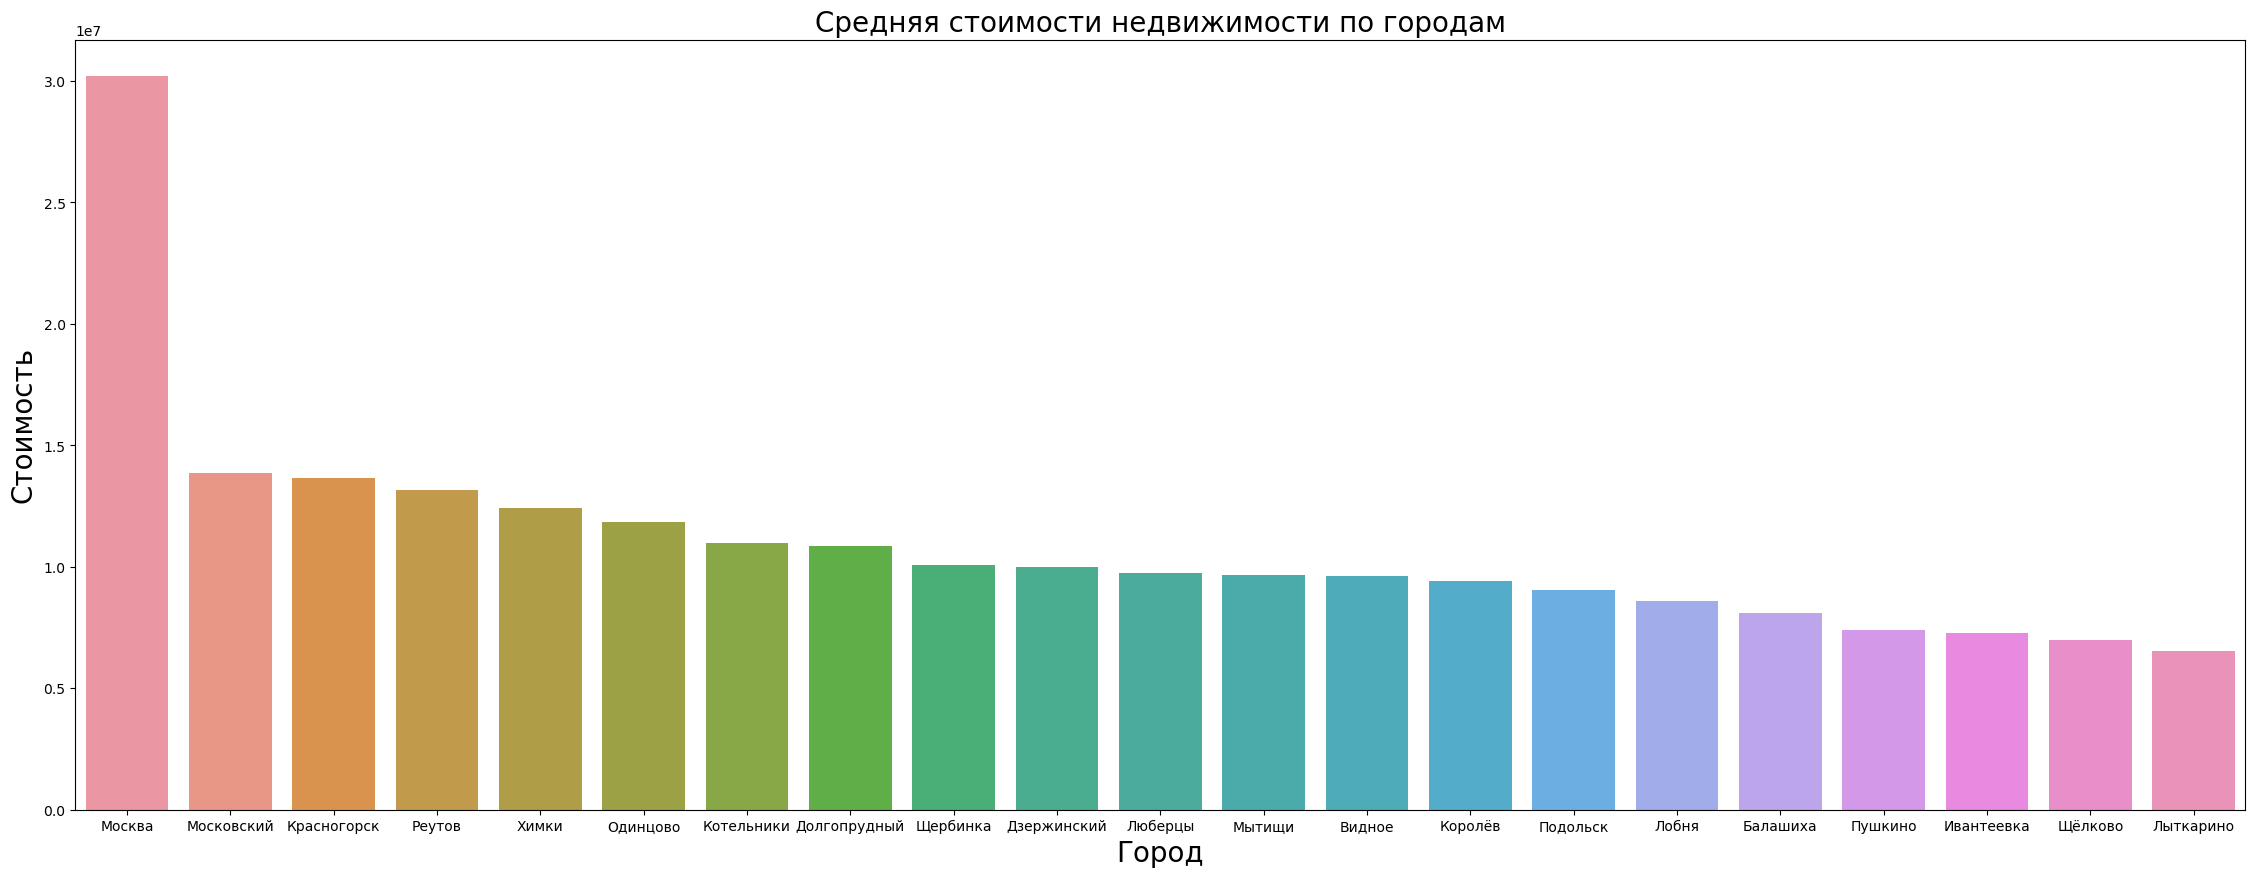

In [14]:
plt.figure(figsize = (28,10))
mean_price_city = (df.groupby(['city'])[['price']].mean().sort_values('price',ascending=False))
mean_price_city['col'] = mean_price_city.index
sns.barplot(data=mean_price_city, x = 'col', y = 'price')
plt.ylabel('Стоимость', fontsize=20)
plt.xlabel('Город', fontsize=20)
plt.title('Средняя стоимости недвижимости по городам',fontsize=20)

plt.show()

- Из графика видно, что стоимость недвижимости в Москве существенно превышает стоимость недвидимости в других городах. 
- Исходя из этого, целесообразно выделить данный факт в отдельный признак в процессе feature engineering.

C:\Users\sanek\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sanek\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


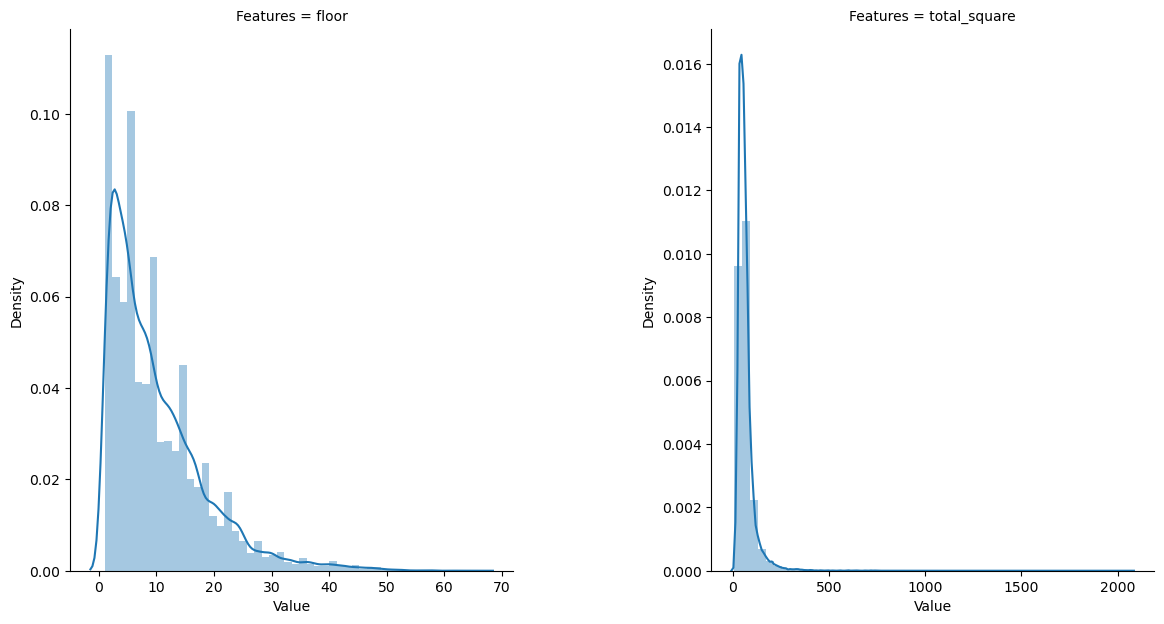

In [15]:
num_cols = ['floor', 'total_square']
numeric_features = df[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                   col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=2, right=2)
plt.show()

In [16]:
def outliners(col):
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    perc25 = df[col].quantile(0.25)
    l = perc25 - 1.5*IQR
    r = perc75 + 1.5*IQR
    print('Для {0}  IQR: {1}'.format(col,IQR),'границы [{0},{1}]'.format(l,r))
    print('колличество выбросов:{}'.format(df[df[col]<l][col].count() + df[df[col]>r][col].count()))

In [17]:
# логарифмирование численных признаков
for i in num_cols:
    outliners(i)

Для floor  IQR: 10.0 границы [-11.0,29.0]
колличество выбросов:3224
Для total_square  IQR: 35.6 границы [-13.300000000000004,129.10000000000002]
колличество выбросов:5897


In [18]:
# логарифмирование численных признаков
for i in num_cols:
    df[i] = df[i].apply(lambda x: np.log(1+x))

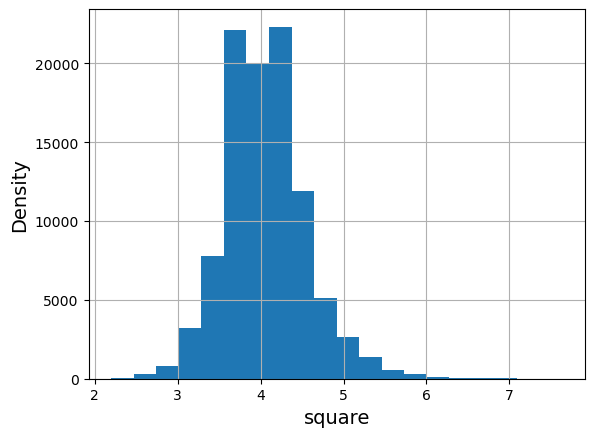

In [19]:
df['total_square'].hist(bins = 20)
plt.ylabel('Density', fontsize=14)
plt.xlabel('square', fontsize=14)
plt.show()

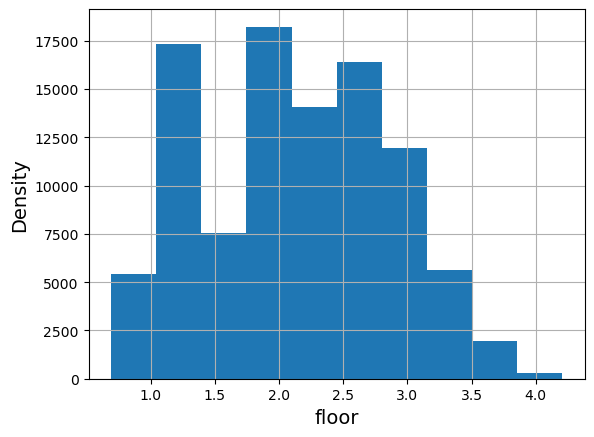

In [20]:
df['floor'].hist(bins = 10)
plt.ylabel('Density', fontsize=14)
plt.xlabel('floor', fontsize=14)
plt.show()

## Feature engineering

### _удаление колонок_ 


In [21]:
df.drop(['period','lat', 'lon','description'], inplace = True, axis = 1 )

### _добавление новых признаков_ 

In [22]:
df['Moscow'] = df['city'].apply(lambda x: 1 if x == 'Москва' else 0)

# Разбиение данных 

In [23]:
df['address_name'] = df['address_name'].astype(str)
df['city'] = df['city'].astype(str)
df['settlement'] = df['settlement'].astype(str)
df['district'] = df['district'].astype(str)
df['area'] = df['area'].astype(str)
df['product_name'] = df['product_name'].astype(str)
df['postcode'] = df['postcode'].astype(str)
df['rooms'] = df['rooms'].astype(str)
df['object_type'] = df['object_type'].astype(str)
df['source'] = df['source'].astype(str)

In [24]:
x = df.drop('price', axis = 1)
y = df[['price']]
x_train, x_test, y_train, y_test = train_test_split(x,y)

In [25]:
cat_features = ['product_name', 'postcode', 'address_name', 'object_type',
        'rooms', 'city', 'settlement', 'district',
       'area',  'source']

In [26]:
df.isna().sum()

product_name    0
price           0
postcode        0
address_name    0
object_type     0
total_square    0
rooms           0
floor           0
city            0
settlement      0
district        0
area            0
source          0
Moscow          0
dtype: int64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98822 entries, 0 to 98821
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  98822 non-null  object 
 1   price         98822 non-null  int64  
 2   postcode      98822 non-null  object 
 3   address_name  98822 non-null  object 
 4   object_type   98822 non-null  object 
 5   total_square  98822 non-null  float64
 6   rooms         98822 non-null  object 
 7   floor         98822 non-null  float64
 8   city          98822 non-null  object 
 9   settlement    98822 non-null  object 
 10  district      98822 non-null  object 
 11  area          98822 non-null  object 
 12  source        98822 non-null  object 
 13  Moscow        98822 non-null  int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 10.6+ MB


# Model

## _baseline_

In [28]:
model = CatBoostRegressor( cat_features =cat_features)
model.fit(x_train, y_train,  verbose = 0, cat_features = cat_features)
mean_absolute_error(y_test, model.predict(x_test) ) 

3845103.4438707163

In [28]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,total_square,54.775036
1,district,15.454857
2,postcode,9.693825
3,floor,4.819550
4,area,4.369881
5,address_name,3.497916
6,rooms,2.861235
7,source,1.422781
8,city,1.399420
9,settlement,1.029623


## Optuna

In [105]:
def objective(trial, X, y):
    
    param_grid = {
        "iterations": 20000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 3, 10, step=2),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100, step=10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg",2,40,5)
    }
    
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    cv_predicts = np.empty(3)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model = CatBoostRegressor(**param_grid)
        model.fit(X_train,y_train,eval_set=[(X_test, y_test)],verbose=0,cat_features = cat_features)
        preds = model.predict(X_test)        
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return  np.mean(cv_predicts)

In [116]:
#study = optuna.create_study(direction="minimize")
#func = lambda trial: objective(trial, x_train, y_train)
#study.optimize(func, n_trials=3, show_progress_bar=True)
#best_params_cat = study.best_params

In [31]:
#study.best_params
best_params_cat = {'learning_rate': 0.02447502794754966, 
                   'depth': 9, 
                   'min_data_in_leaf': 85, 
                   'l2_leaf_reg': 27,
                  "iterations": 20000}


In [32]:
model = CatBoostRegressor( **best_params_cat, cat_features =cat_features)
model.fit(x_train, y_train,  verbose = 0, cat_features = cat_features)
loss = mean_absolute_error(y_test, model.predict(x_test) ) 
print('Oшибка предсказания модели = {0} руб'.format(loss))


Oшибка предсказания модели = 3396935.202479545 руб


- В процессе моделирования процесса ценообразования стоимости недвижимости была разработана регрессионная модель, со средней разность между спрогнозированным и фактическим значениями цены равной 3396935 рублей
-  Ключивыми факторами в процессе ценообразования стоимости недвижимости являются: общая площадь недвижимости и место расположения объекта.
- На диаграмме ниже приведен вклад каждого из признаков модели в процесс ценообразования стоимости недвижимости.

- В дальнейшем целесообразно применить кластеризацию для разбиения объектов недвижимости на группы и каждую группу рассматриваить независимо от других групп.

(array([ 0., 10., 20., 30., 40., 50., 60.]),
 [Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40'),
  Text(0, 50.0, '50'),
  Text(0, 60.0, '60')])

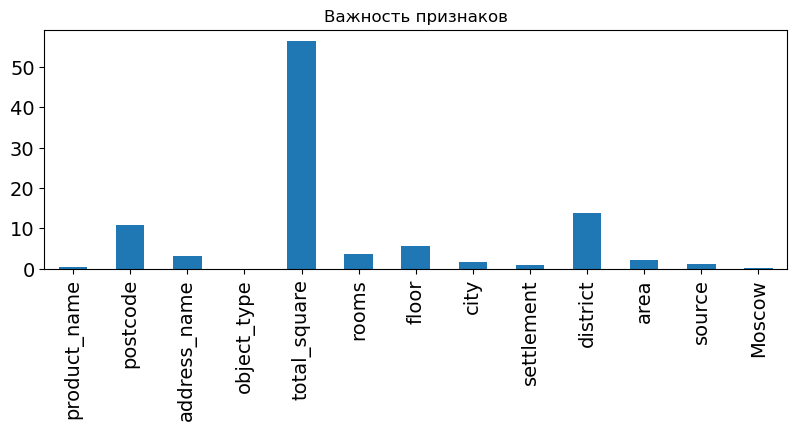

In [33]:
cat_wine_imp = pd.Series(model.get_feature_importance(), x_test.columns)
fig, ax = plt.subplots(figsize=(8,4))
cat_wine_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)